In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modules.numeric import *
from modules.plotting import *
cmap = get_cmap()

In [186]:
L = 40
N = 1000 #int(L/40*1000)
DX = L/(N - 1)
DT = 0.7*DX
LAMB = 2
X0 = 10 #15*delta(lamb)/2 #L/3

H = 0.2
COLLIDER = KinkCollider(0, -L, N, (-X0, X0), DT, DX, order=4, H=H)

In [201]:
v = 0.1714956
field = kink_boundary(-X0, v, LAMB, H=H)
phi = lambda x: field(x, 0)
phi_dt = lambda x: field.diff(1)(x, 0)
y0 = np.stack((
    phi(COLLIDER.x), 
    phi_dt(COLLIDER.x)
))

t_final = L/v
t, Y = rk4_solve(COLLIDER.get_system(lamb=LAMB), y0, DT, t_final)
y = Y[:, 0]

(0.0, 100.0)

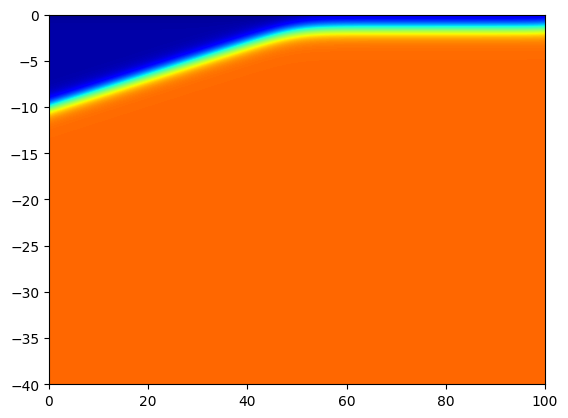

In [202]:
plt.imshow(y.T, cmap='jet', aspect='auto', extent=(t.min(), t.max(), COLLIDER.x.min(), COLLIDER.x.max()))
plt.xlim(0, 100)